In [130]:
'''
Project Name: IDS 705 Machine Learning Kaggle Competition --- Solar PV in Aerial Imagery
Programmer: Guillem Amat, Calvin Dong, Jose Luis Moscoso, Varun Prasad, Anshupriya Srivastava
Date: 03-05-2020
Version: 3

Tasks:
1. Develop Convolutional Neural Network
2. Predict scores and labels for all train data by CNN
3. Develop Baseline Model (Grey scaled Gradient Boosting)
4. Predict scores for all train data by Baseline Model
5. Create figures of ROC, PR and Confusion Matrices
6. Predict scores for test data by CNN
'''

# Package import
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

In [57]:
# Set the directories for the data and the CSV files that contain ids/labels

'''
Please note: 

Folders under the directory: dir_images (showed below) have been set up before data input, which means 
there should be four folders named as:
1. 'train' which is randomly selected from all train data (we randomly selected 80%) for training process
2. 'val' which is randomly selected from all train data (we randomly selected 20%) for validation
3. 'test' which includes all test data for Kaggle competition
4. 'all train' which includes all train data for assessing model performance

Every folder above should has saved images in correct subfolders which are labeled as '1' and '0'.
For 'test' and 'all train', because we only use them to do prediction and disregard what are original labels,
it's ok to save images in either '1' or '0', but still need both under upper level folders
'''

dir_images  = '/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020'
dir_train_images  = '/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/training/'
dir_test_images   = '/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/testing/'
dir_train_labels  = '/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/labels_training.csv'
dir_val_labels  = '/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/val_labels.csv'


In [97]:
# CNN
# Data augmentation and normalization for training
# Just normalization for validation and test 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(101),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(101,101),
        transforms.CenterCrop(101),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(101,101),
        transforms.CenterCrop(101),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train_all': transforms.Compose([
        transforms.Resize(101,101),
        transforms.CenterCrop(101),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    }

data_dir = dir_images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[['0' '0' '0' '0' '1' '1' '0' '0']
 ['0' '0' '0' '1' '1' '0' '0' '1']
 ['0' '0' '0' '0' '1' '0' '1' '0']
 ['0' '0' '0' '0' '1' '0' '1' '0']
 ['0' '0' '0' '0' '0' '1' '0' '0']
 ['0' '0' '0' '1' '0' '1' '0' '1']
 ['0' '0' '1' '0' '0' '0' '0' '0']
 ['0' '1' '0' '1' '0' '0' '0' '0']]


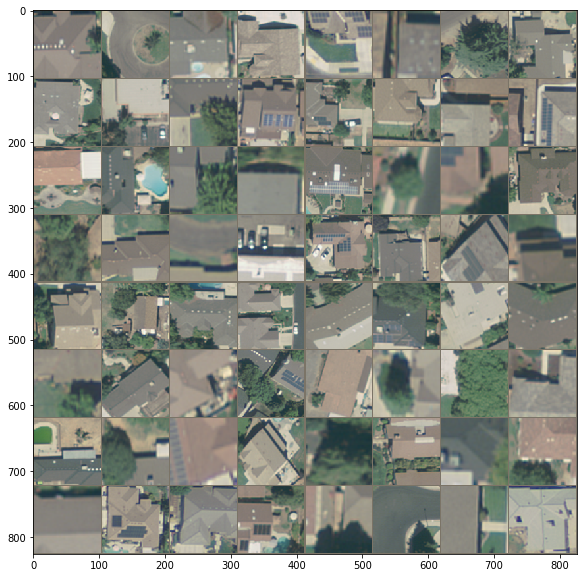

In [119]:
# Visualize Raw Data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title,loc='right')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.rcParams['figure.figsize']=10,10

imshow(out, title=print(np.asarray([class_names[x] for x in classes]).reshape(8,8)))

In [5]:
# Define train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    predict = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Original train model is pretrained ResNet34
model_ft = models.resnet34(pretrained=True)

#Set up linear layer
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

#model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

#O ptimizer Stochastic Gradient Decent
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
# Train Model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6854 Acc: 0.7275
val Loss: 0.3407 Acc: 0.8736

Epoch 1/24
----------
train Loss: 0.4386 Acc: 0.8259
val Loss: 0.2303 Acc: 0.9080

Epoch 2/24
----------
train Loss: 0.4035 Acc: 0.8585
val Loss: 0.1878 Acc: 0.9425

Epoch 3/24
----------
train Loss: 0.3905 Acc: 0.8762
val Loss: 0.2664 Acc: 0.9425

Epoch 4/24
----------
train Loss: 0.3540 Acc: 0.8776
val Loss: 0.1812 Acc: 0.9310

Epoch 5/24
----------
train Loss: 0.2997 Acc: 0.9023
val Loss: 0.1326 Acc: 0.9425

Epoch 6/24
----------
train Loss: 0.2424 Acc: 0.9130
val Loss: 0.2316 Acc: 0.9310

Epoch 7/24
----------
train Loss: 0.1973 Acc: 0.9349
val Loss: 0.0752 Acc: 0.9770

Epoch 8/24
----------
train Loss: 0.1940 Acc: 0.9342
val Loss: 0.0799 Acc: 0.9770

Epoch 9/24
----------
train Loss: 0.1639 Acc: 0.9476
val Loss: 0.0774 Acc: 0.9770

Epoch 10/24
----------
train Loss: 0.1874 Acc: 0.9384
val Loss: 0.0878 Acc: 0.9770

Epoch 11/24
----------
train Loss: 0.1603 Acc: 0.9455
val Loss: 0.0907 Acc: 0.9770

Ep

In [92]:
# Save Model
torch.save(model_ft.state_dict(),"/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/resnet_model.pt")

In [76]:
# Assessment Metrics
epoch=list(range(1,26))
train_loss=[0.6854,0.4386,0.4035,0.3905,0.3540,0.2997,0.2424,0.1973,0.1940,0.1639,0.1874,
           0.1603,0.1717,0.1538,0.1595,0.1549,0.1924,.1549,0.1676,0.1508,0.1483,0.1489,0.1688,
           0.1601,0.1696]
val_loss=[0.3407,0.2303 , 0.1878  ,.2664  ,.1812  ,.1326  ,.2316 ,.0752 ,.0799 ,.0774 ,
          .0878 ,.0907,.0851 ,.0721 ,.0563 ,.1022, .0704 ,.0598 ,.0659 ,.0666 ,.0499 ,
         .0570 ,.0606 ,.0665 ,.0519]
train_acc=[.7275,.8259,.8585,.8762,.8776,.9023,.9130,.9349,.9342,.9476,.9384,.9445,.9469,
           .9455,.9462,.9462,.9349,.9519,.9427,.9519,.9519,.9505,.9406,.9420,.9448]
val_acc=[.8736,.9080,.9425,.9425,.9310,.9425,.9310,.9770,.9770,.9770,.9770,.9770,.9770,
        .9655,.9770,.9770,.9655,.9655,.9770,.9655,.9885,.9885,.9770,.9655,.9885]

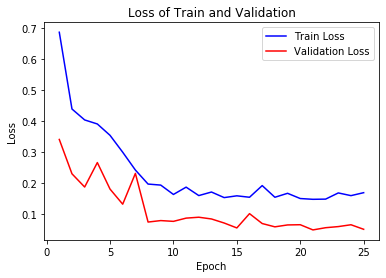

In [264]:
# Loss of Train and Validation
plt.rcParams['figure.figsize']=6,4
plt.plot(epoch,train_loss,"r",label='Train Loss',color='blue')
plt.plot(epoch,val_loss,"r",label='Validation Loss',color="red")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss of Train and Validation")
plt.show()

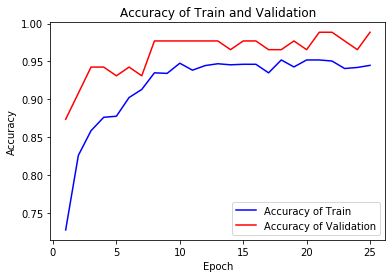

In [265]:
# Accuracy of Train and Validation
plt.rcParams['figure.figsize']=6,4

plt.plot(epoch,train_acc,"r",label='Accuracy of Train',color='blue')
plt.plot(epoch,val_acc,"r",label='Accuracy of Validation',color="red")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of Train and Validation")
plt.show()

In [59]:
# Reload all train and test data and reset batch size for prediction
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_all','train','test','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, 
                                              num_workers=1)
              for x in ['train_all','train','test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_all','train', 'test','val']}
#class_names = image_datasets['train'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
# Predict all train
model_ft.eval()

ids_all = []
predictions = []
label = []

for inputs, lab in dataloaders['train_all']:
    inputs = inputs.to(device)

    with torch.set_grad_enabled(False):
        y_pred = model_ft(inputs)
        p = torch.nn.functional.softmax(y_pred, dim=1)
        _, preds = torch.max(y_pred, 1)
        predictions.append(p.numpy().tolist())
        label.append(preds)
        
#print("Done making predictions!")

pred=np.asarray(predictions).reshape(len(predictions),2)
pred=pred[:,1].tolist()

Done making predictions!


In [139]:
# Create labels of CNN predictions based on cut-off = 0.5
cnn_labels=[]
for i in pred:
    if i>=0.5:
        cnn_labels.append(1)
    else:
        cnn_labels.append(0)

In [126]:
# Baseline model (Grey scale, Gradient Boosting)

# Data loading
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    
    if training==False:
        scores = labels_pd.score.values
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids, scores

# Change RGB to Grey Scale    
def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # extract the mean and standard deviation of each sample as features
    feature_mean = np.mean(vectorized_data,axis=1)
    feature_std  = np.std(vectorized_data,axis=1)
    
    # Combine the extracted features into a single feature vector
    features = np.stack((feature_mean,feature_std),axis=-1)
    
    return features

# Set Gradient Boosting

def set_classifier_GradientBoostingClassifier():
    
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    gb=GradientBoostingClassifier()
    
    return gb

# Prediction based on Cross Validation

def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores


In [ ]:
# Train Baseline Model and predict all train data
train_data, train_labels = load_data(dir_train_images,dir_train_labels, True)
train_feat = preprocess_and_extract_features(train_data)
clf = set_classifier_GradientBoostingClassifier()
pred_score=cv_performance_assessment(train_data,train_labels,5,clf)

# Load All Train Labels
train_all_labels=pd.read_csv(dir_train_labels)
labels = train_all_labels.label.values
#labels

In [ ]:
# Check Misclassification of CNN
mis_id=[]
mis_labels=[]
mis_pred=[]
for i in range(len(labels)):
    if labels[i] != cnn_labels[i]:
        mis_id.append(i)
        mis_pred.append(pred[i])
        mis_labels.appedn(cnn_labels[i])
        print(i,pred[i])
#submissions = pd.DataFrame({"score":mis})
submissions = pd.DataFrame({"id":mis_id, "labels":mis_labels, "score":pred})
pd.DataFrame.to_csv(submissions,'/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/pred_train.csv')

In [266]:
# Read in other three models results

svm_labels = pd.read_csv("/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/trainingsvm.csv")
svm_labels = svm_labels.score.values
knn_pred = pd.read_csv("/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/trainingknn.csv")
knn_pred = knn_pred.score.values
rf_pred = pd.read_csv("/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/trainingrf.csv")
rf_pred = rf_pred.score.values

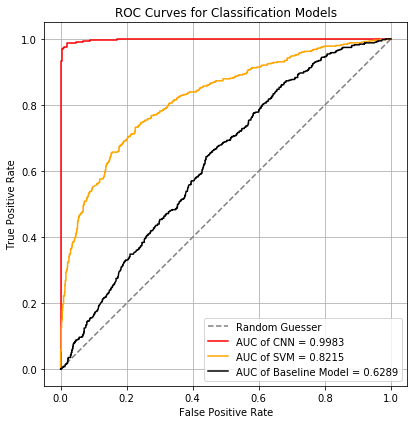

In [256]:
# ROC
fpr1, tpr1, threshold = metrics.roc_curve(labels, pred)
roc_auc1 = metrics.auc(fpr1, tpr1)

fpr2, tpr2, threshold = metrics.roc_curve(train_labels, pred_score)
roc_auc2 = metrics.auc(fpr2, tpr2)

fpr3, tpr3, threshold = metrics.roc_curve(labels, svm_labels)
roc_auc3 = metrics.auc(fpr3, tpr3)

plt.rcParams['figure.figsize']=6,6

plt.plot([0,1],[0,1],'--', color='gray', label='Random Guesser')
plt.plot(fpr1, tpr1, label = 'AUC of CNN = %0.4f' % roc_auc1, color="red")
plt.plot(fpr3, tpr3, label = 'AUC of SVM = %0.4f' % roc_auc3, color="orange")
plt.plot(fpr2, tpr2, label = 'AUC of Baseline Model = %0.4f' % roc_auc2, color="black")

plt.legend(loc = 'lower right')
plt.title("ROC Curves for Classification Models")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.grid('on')
plt.axis('square')
plt.tight_layout()
plt.show()

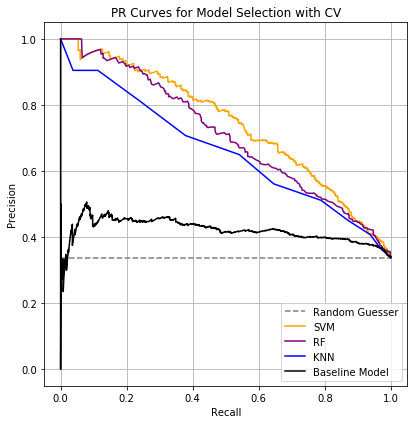

In [272]:
# Precision Recall Curve
plt.rcParams['figure.figsize']=6,6

pr1, rc1, threshold = metrics.precision_recall_curve(labels, pred)
pr_auc1 = metrics.auc(rc1, pr1)

pr2, rc2, threshold = metrics.precision_recall_curve(train_labels, pred_score)
pr_auc2 = metrics.auc(rc2, pr2)

pr3, rc3, threshold = metrics.precision_recall_curve(labels, svm_labels)
pr_auc3 = metrics.auc(rc3, pr3)

pr4, rc4, threshold = metrics.precision_recall_curve(labels, knn_pred)
pr_auc4 = metrics.auc(rc4, pr4)

pr5, rc5, threshold = metrics.precision_recall_curve(labels, rf_pred)
pr_auc5 = metrics.auc(rc5, pr5)

plt.plot([0,1],[0.337,0.337],'--', color='gray', label='Random Guesser')
#plt.plot(rc1, pr1, 'b', label = 'CNN', color="red")
plt.plot(rc3, pr3, 'b', label = "SVM", color="orange")
plt.plot(rc5, pr5, label = 'RF', color="purple")
plt.plot(rc4, pr4, label = 'KNN', color="blue")
plt.plot(rc2, pr2, 'b', label = 'Baseline Model', color="black")

plt.legend(loc = 'lower right')
#plt.title("PR Curves for Classification Models")
plt.title("PR Curves for Model Selection with CV")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid('on')
plt.axis('square')
plt.tight_layout()
plt.show()


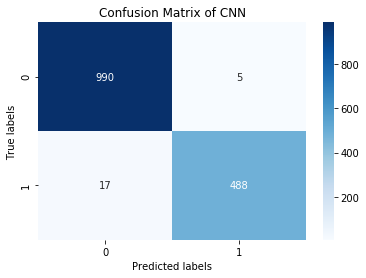

In [274]:
# Confusion Matrix of CNN

cm = confusion_matrix(labels, cnn_labels)
cm = cm.astype('float')

plt.rcParams['figure.figsize']=6,4

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of CNN'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

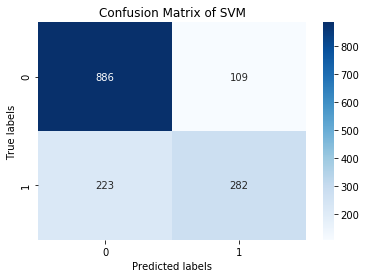

In [275]:
# Confusion Matrix of SVM

svc_labels_binary=[]
for i in svm_labels:
    if i>=0.5:
        svc_labels_binary.append(1)
    else:
        svc_labels_binary.append(0) 

cm = confusion_matrix(labels, svc_labels_binary)
cm = cm.astype('float')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of SVM'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [ ]:
# Predict all test
model_ft.eval()

ids_all = []
predictions = []
label = []

for inputs, lab in dataloaders['test']:
    inputs = inputs.to(device)

    with torch.set_grad_enabled(False):
        y_pred = model_ft(inputs)
        p = torch.nn.functional.softmax(y_pred, dim=1)
        _, preds = torch.max(y_pred, 1)
        predictions.append(p.numpy().tolist())
        label.append(preds)
        
#print("Done making predictions!")

pred=np.asarray(predictions).reshape(len(predictions),2)
pred=pred[:,1].tolist()
submissions = pd.DataFrame({"id":list(range(1500,2058)),"score":pred})
pd.DataFrame.to_csv(submissions,'/Users/Calvin/Desktop/2020Spring/IDS705_Machine_Learning/Kaggle_Competition/ids705sp2020/submission/sub20.csv')
